# Nichesphere differential co-localization tutorial

Nichesphere is an sc-verse compatible Python library which allows the user to find differentially co-localized cellular niches and biological processes involved in their interactions based on cell type pairs co-localization probabilities in different conditions. Cell type pair co-localization probabilities are obtained in different ways: from deconvoluted Visium 10x / PIC-seq data (probabilities of finding each cell type in each spot / multiplet), or counting cell boundaries overlaps for each cell type pair in single cell spatial data (MERFISH , CODEX ...). This tutorial focuses on defining groups of cells that converge or split in disease (Ischemia) based on differential co-localization. 

Nichesphere also offers the possibility to look at localized differential cell - cell communication based on Ligand-Receptor pairs expression data, such as results from CrossTalkeR [ref]. This is addressed in the localized differential communication tutorial.


## Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import networkx as nx
import warnings
import scanpy as sc
import leidenalg
import sklearn
import igraph as ig
warnings.filterwarnings("ignore")

## My package test
#import sys
#sys.path.append("/data/hu367653/source/Nichesphere-main/nichesphere/nichesphere")
#import tl_new
import nichesphere

In [2]:
import mudata as md

## Data at first glance

In this example we will use data from the Myocardial Infarction atlas from Kuppe, C. et. Al., 2022

In [3]:
mudata=md.read('/data/Graph4Patients/data/final_objects/heart_MI_ST_SC_23samples.h5mu')

This is a subset with 23 samples (samples with less than 1500 cells in the snRNA-seq data were filtered out), and 33 different cell subtypes

Deconvoluted data (Cell type probabilities per spot): In a previous step, we used MOSCOT to deconvolute cell subtypes in visium slices from the same 23 samples , getting matrices of probabilities of each cell of being in each spot.

Then we got cell type probabilities per spot summing the probabilities of cells of the same kind in each spot; thus getting concatenated cell type probability matrices for all samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [4]:
CTprops=pd.read_csv('./CTprops.csv', index_col=0)
CTprops

Fib1_SCARA5  \
AAACAAGTATCTCCCA-1-1-0-0-0                          0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                          0.000000e+00   
AAACACCAATAACTGC-1-1-0-0-0                          0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                          1.373226e-25   
AAACAGCTTTCAGAAG-1-1-0-0-0                          0.000000e+00   
...                                                          ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   

                                                      damaged_CM  \
AAACAAGTATCTCCCA-1-1-0-0-0                          0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                          2.691729e-21   
AAACACCAATAACTGC-1-1-0-0-0                          0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                          0.000000e+00   
AAACAGCTTTCAGAAG-1-1-0-0-0                          0.000000e+00   
...                                                          ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  3.327203e-01   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000e+00   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  5.445488e-01   

                                                    Capillary_Endo  \
AAACAAGTATCTCCCA-1-1-0-0-0                            0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                            0.000000e+00   
AAACACCAATAACTGC-1-1-0-0-0                            0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                            0.000000e+00   
AAACAGCTTTCAGAAG-1-1-0-0-0                            0.000000e+00   
...                                                            ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    1.621940e-18   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...    0.000000e+00   

                                                    LYVE_FOLR_Macrophages  \
AAACAAGTATCTCCCA-1-1-0-0-0                                   8.333133e-16   
AAACAATCTACTAGCA-1-1-0-0-0                                   0.000000e+00   
AAACACCAATAACTGC-1-1-0-0-0                                   0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                                   0.000000e+00   
AAACAGCTTTCAGAAG-1-1-0-0-0                                   0.000000e+00   
...                                                                   ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTTCACATCCAGG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTTCATTAGTCTA-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   
TTGTTTCCATACAACT-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...           0.000000e+00   

                                                     Fib3_C7    healthy_CM  \
AAACAAGTATCTCCCA-1-1-0-0-0                          0.000000  0.000000e+00   
AAACAATCTACTAGCA-1-1-0-0-0                          0.445912  5.540884e-01   
AAACACCAATAACTGC-1-1-0-0-0                          0.000000  0.000000e+00   
AAACAGAGCGACTCCT-1-1-0-0-0                          0.499762  3.111796e-13   
AAACAGCTTTCAGAAG-1-1-0-0-0                          0.000000  0.000000e+00   
...                                                      ...           ...   
TTGTGTTTCCCGAAAG-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-...  0.000000  6.455526e-01   
TTGTTGTGTGTCAAGA-1-0-0-0-0-0-

## Co-localization

We computed then co-localization probabilities from the cell type probability matrices. Here we got concatenated co-localization sample matrices of cell type x cell type.

Then we reshaped the co-localization data into a matrix of cell type pairs x samples.

(you can have a closer look at these steps in the preprocessing tutorial)

In [5]:
colocPerSample=pd.read_csv('./colocPerSample.csv', index_col=0)
colocPerSample

Fib1_SCARA5-Fib1_SCARA5  Fib1_SCARA5-damaged_CM  \
control_P17                 0.017603            3.084543e-04   
RZ_P9                       0.009307            4.289964e-04   
IZ_P15                      0.030351            0.000000e+00   
RZ_P6                       0.040470            4.409681e-04   
RZ_BZ_P3                    0.021508            2.924325e-04   
FZ_P14                      0.010915            5.932359e-05   
RZ_BZ_P12                   0.029538            1.290557e-04   
FZ_GT_P4                    0.030297            0.000000e+00   
GT_IZ_P13                   0.018084            0.000000e+00   
GT_IZ_P15                   0.020017            3.980737e-05   
FZ_P20                      0.070308            0.000000e+00   
RZ_FZ_P5                    0.029320            1.307565e-04   
GT_IZ_P9                    0.019715            1.999953e-04   
RZ_P3                       0.057060            1.686446e-03   
FZ_GT_P19                   0.021516            1.100737e-04   
FZ_P18                      0.041702            0.000000e+00   
IZ_P10                      0.030229            9.586357e-05   
control_P7                  0.007382            2.349106e-04   
RZ_P11                      0.010735            8.770894e-31   
control_P1                  0.043871            8.279132e-04   
RZ_BZ_P2                    0.019492            7.422823e-05   
control_P8                  0.022322            8.072949e-04   
RZ_GT_P2                    0.014946            2.958828e-04   

             Fib1_SCARA5-Capillary_Endo  Fib1_SCARA5-LYVE_FOLR_Macrophages  \
control_P17                    0.000992                       2.507278e-04   
RZ_P9                          0.000738                       3.342737e-06   
IZ_P15                         0.000027                       1.859005e-04   
RZ_P6                          0.002752                       3.609917e-04   
RZ_BZ_P3                       0.000567                       5.747034e-05   
FZ_P14                         0.000740                       6.678659e-04   
RZ_BZ_P12                      0.001448                       4.188154e-04   
FZ_GT_P4                       0.000009                       0.000000e+00   
GT_IZ_P13                      0.000154                       3.540328e-04   
GT_IZ_P15                      0.000107                       1.413835e-05   
FZ_P20                         0.000063                       1.740452e-04   
RZ_FZ_P5                       0.002286                       4.717095e-04   
GT_IZ_P9                       0.000250                       3.609267e-33   
RZ_P3                          0.001476                       8.593347e-04   
FZ_GT_P19                      0.000403                       6.173076e-04   
FZ_P18                         0.000663                       1.742412e-04   
IZ_P10                         0.000610                       3.347724e-04   
control_P7                     0.000457                       6.240571e-05   
RZ_P11                         0.001312                       1.102293e-04   
control_P1                     0.001498                       7.997668e-04   
RZ_BZ_P2                       0.000803                       1.589867e-04   
control_P8                     0.002369                       3.393776e-05   
RZ_GT_P2                       0.001215                       2.882729e-04   

             Fib1_SCARA5-Fib3_C7  Fib1_SCARA5-healthy_CM  \
control_P17             0.007062            2.586003e-03   
RZ_P9                   0.005204            1.439230e-03   
IZ_P15                  0.001200            0.000000e+00   
RZ_P6                   0.008687            2.927885e-03   
RZ_BZ_P3                0.002408            4.829458e-04   
FZ_P14                  0.003387            2.537452e-04   
RZ_BZ_P12               0.004993            9.484252e-04   
FZ_GT_P4                0.000385            0.000000e+00   
GT_IZ_P13               0.003069            0.000000e+00   
GT_

The sum of the probabilities of every cell type pair in a sample must be = 1

In [6]:
colocPerSample.sum(axis=1)

control_P17    1.0
RZ_P9          1.0
IZ_P15         1.0
RZ_P6          1.0
RZ_BZ_P3       1.0
FZ_P14         1.0
RZ_BZ_P12      1.0
FZ_GT_P4       1.0
GT_IZ_P13      1.0
GT_IZ_P15      1.0
FZ_P20         1.0
RZ_FZ_P5       1.0
GT_IZ_P9       1.0
RZ_P3          1.0
FZ_GT_P19      1.0
FZ_P18         1.0
IZ_P10         1.0
control_P7     1.0
RZ_P11         1.0
control_P1     1.0
RZ_BZ_P2       1.0
control_P8     1.0
RZ_GT_P2       1.0
dtype: float64

Same cell type interactions will be excluded later on, so we'll have a list of same cell type interaction pairs in order to subset the co-localization table we'll generate in the next step.

In [7]:
cell_types=CTprops.columns
oneCTints=cell_types+'-'+cell_types

Conditions

To subset the samples, we will use a dataframe of sample names and conditions.

In [8]:
sampleTypesDF=pd.read_csv('../../../../nichesphere_tutorial_data/MI_sampleTypesDF.csv')
sampleTypesDF

Unnamed: 0       sample sampleType
0            0  control_P17   myogenic
1            1        RZ_P9     remote
2            2       IZ_P15   ischemic
3            3        RZ_P6     remote
4            4     RZ_BZ_P3     border
5            5       FZ_P14   fibrotic
6            6    RZ_BZ_P12     border
7            7     FZ_GT_P4   fibrotic
8            8    GT_IZ_P13   ischemic
9            9    GT_IZ_P15   ischemic
10          10       FZ_P20   fibrotic
11          11     RZ_FZ_P5   fibrotic
12          12     GT_IZ_P9   ischemic
13          13        RZ_P3     remote
14          14    FZ_GT_P19   fibrotic
15          15       FZ_P18   fibrotic
16          16       IZ_P10   ischemic
17          17   control_P7   myogenic
18          18       RZ_P11     remote
19          19   control_P1   myogenic
20          20     RZ_BZ_P2     border
21          21   control_P8   myogenic
22          22     RZ_GT_P2     remote

Differential co-localization analysis

We will test differential co-localization between two different conditions using Wilcoxon (rank sums) tests. Here we will focus on the differences between myogenic and ischemic samples.

In [9]:
myo_iscDF=nichesphere.coloc.diffColoc_test(coloc_pair_sample=colocPerSample, sampleTypes=sampleTypesDF, exp_condition='ischemic', ctrl_condition='myogenic')
myo_iscDF

pairs  \
pairs                                                                  
Fib1_SCARA5-Fib1_SCARA5                      Fib1_SCARA5-Fib1_SCARA5   
Fib1_SCARA5-damaged_CM                        Fib1_SCARA5-damaged_CM   
Fib1_SCARA5-Capillary_Endo                Fib1_SCARA5-Capillary_Endo   
Fib1_SCARA5-LYVE_FOLR_Macrophages  Fib1_SCARA5-LYVE_FOLR_Macrophages   
Fib1_SCARA5-Fib3_C7                              Fib1_SCARA5-Fib3_C7   
...                                                              ...   
NK_T-NK                                                      NK_T-NK   
NK_T-CD_8                                                  NK_T-CD_8   
NK_T-Purkinje_fibers                            NK_T-Purkinje_fibers   
NK_T-Adipo                                                NK_T-Adipo   
NK_T-NK_T                                                  NK_T-NK_T   

                                  statistic   p-value  
pairs                                                  
Fib1_SCARA5-Fib1_SCARA5            0.489898  0.624206  
Fib1_SCARA5-damaged_CM             -2.44949  0.014306  
Fib1_SCARA5-Capillary_Endo        -2.204541  0.027486  
Fib1_SCARA5-LYVE_FOLR_Macrophages -0.489898  0.624206  
Fib1_SCARA5-Fib3_C7                -2.44949  0.014306  
...                                     ...       ...  
NK_T-NK                           -0.979796  0.327187  
NK_T-CD_8                         -0.857321  0.391267  
NK_T-Purkinje_fibers                    0.0       1.0  
NK_T-Adipo                        -0.612372  0.540291  
NK_T-NK_T                          0.734847  0.462433  

[1089 rows x 3 columns]

We'll visualize the Wilcoxon test scores in a heatmap

In [10]:
#### test HM
## Not filtering
myo_isc_HM=nichesphere.tl.pval_filtered_HMdf(testDF=myo_iscDF, oneCTinteractions=oneCTints, p=1, cell_types=cell_types)

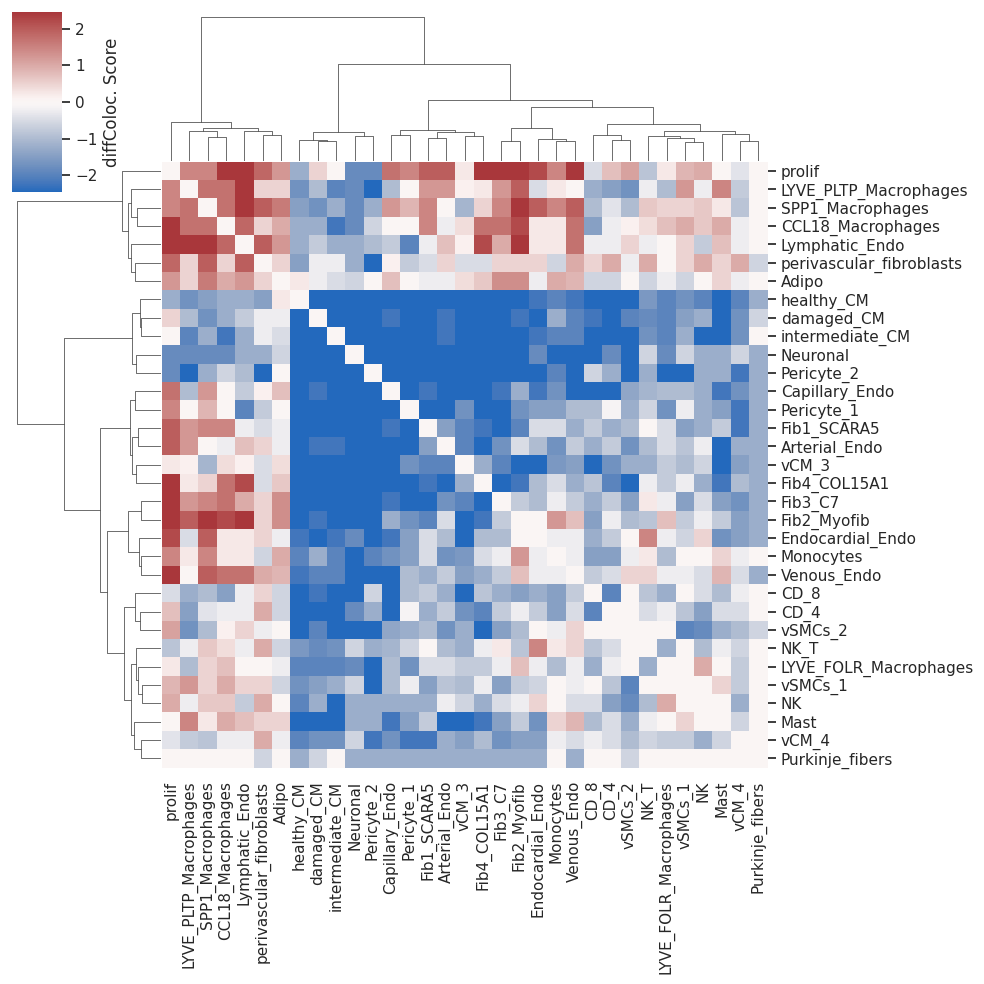

In [11]:
## Plot heatmap
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'})

To get groups of interacting cells , we will cut the hierarchical clustering dendrogram from the clustermap above, obtaining 4 clusters

In [12]:
#### Clusters from clustermap on scores matrix
heatClusts=scipy.cluster.hierarchy.fcluster(plot.dendrogram_col.linkage, 1.9, depth=3)
nichesDF=pd.Series(heatClusts, index=plot.dendrogram_col.data.columns)

In [13]:
nichesDF

Fib1_SCARA5                 3
damaged_CM                  2
Capillary_Endo              3
LYVE_FOLR_Macrophages       5
Fib3_C7                     4
healthy_CM                  2
Fib2_Myofib                 4
Endocardial_Endo            4
Arterial_Endo               3
Neuronal                    2
Pericyte_1                  3
LYVE_PLTP_Macrophages       1
intermediate_CM             2
vCM_3                       3
Pericyte_2                  2
Mast                        5
Monocytes                   4
Fib4_COL15A1                3
SPP1_Macrophages            1
Venous_Endo                 4
vCM_4                       5
prolif                      1
vSMCs_1                     5
CCL18_Macrophages           1
perivascular_fibroblasts    1
CD_4                        5
vSMCs_2                     5
Lymphatic_Endo              1
NK                          5
CD_8                        5
Purkinje_fibers             5
Adipo                       1
NK_T                        5
dtype: int

The we will annotate our cell groups and visualise them with different colors in the co-localization network , for which we will need a niche assignment dictionary (change the keys of this dictionary for your preferred names)

In [14]:
niches_dict={'1_':list(nichesDF.index[nichesDF==1]),
     '2_':list(nichesDF.index[nichesDF==2]),
     '3_':list(nichesDF.index[nichesDF==3]),
     '4_':list(nichesDF.index[nichesDF==4]),
     '5_':list(nichesDF.index[nichesDF==5]),
     }

We will assign each group a color too

In [15]:
#Niches colors
clist=['#17becf', '#ffff33', '#f781bf', '#4daf4a', '#984ea3']
niche_cols=pd.Series(clist, index=['1_', '2_', '3_', '4_', '5_'])

And we will assign each cell its group and group based color as well

In [16]:
niches_df=nichesphere.tl.cells_niche_colors(CTs=CTprops.columns, niche_colors=niche_cols, niche_dict=niches_dict)
niches_df

cell niche    color
cell                                                             
Fib1_SCARA5                            Fib1_SCARA5    3_  #f781bf
damaged_CM                              damaged_CM    2_  #ffff33
Capillary_Endo                      Capillary_Endo    3_  #f781bf
LYVE_FOLR_Macrophages        LYVE_FOLR_Macrophages    5_  #984ea3
Fib3_C7                                    Fib3_C7    4_  #4daf4a
healthy_CM                              healthy_CM    2_  #ffff33
Fib2_Myofib                            Fib2_Myofib    4_  #4daf4a
Endocardial_Endo                  Endocardial_Endo    4_  #4daf4a
Arterial_Endo                        Arterial_Endo    3_  #f781bf
Neuronal                                  Neuronal    2_  #ffff33
Pericyte_1                              Pericyte_1    3_  #f781bf
LYVE_PLTP_Macrophages        LYVE_PLTP_Macrophages    1_  #17becf
intermediate_CM                    intermediate_CM    2_  #ffff33
vCM_3                                        vCM_3    3_  #f781bf
Pericyte_2                              Pericyte_2    2_  #ffff33
Mast                                          Mast    5_  #984ea3
Monocytes                                Monocytes    4_  #4daf4a
Fib4_COL15A1                          Fib4_COL15A1    3_  #f781bf
SPP1_Macrophages                  SPP1_Macrophages    1_  #17becf
Venous_Endo                            Venous_Endo    4_  #4daf4a
vCM_4                                        vCM_4    5_  #984ea3
prolif                                      prolif    1_  #17becf
vSMCs_1                                    vSMCs_1    5_  #984ea3
CCL18_Macrophages                CCL18_Macrophages    1_  #17becf
perivascular_fibroblasts  perivascular_fibroblasts    1_  #17becf
CD_4                                          CD_4    5_  #984ea3
vSMCs_2                                    vSMCs_2    5_  #984ea3
Lymphatic_Endo                      Lymphatic_Endo    1_  #17becf
NK                                              NK    5_  #984ea3
CD_8                                          CD_8    5_  #984ea3
Purkinje_fibers                    Purkinje_fibers    5_  #984ea3
Adipo                                        Adipo    1_  #17becf
NK_T                                          NK_T    5_  #984ea3

Then we can have a nicer niches heatmap

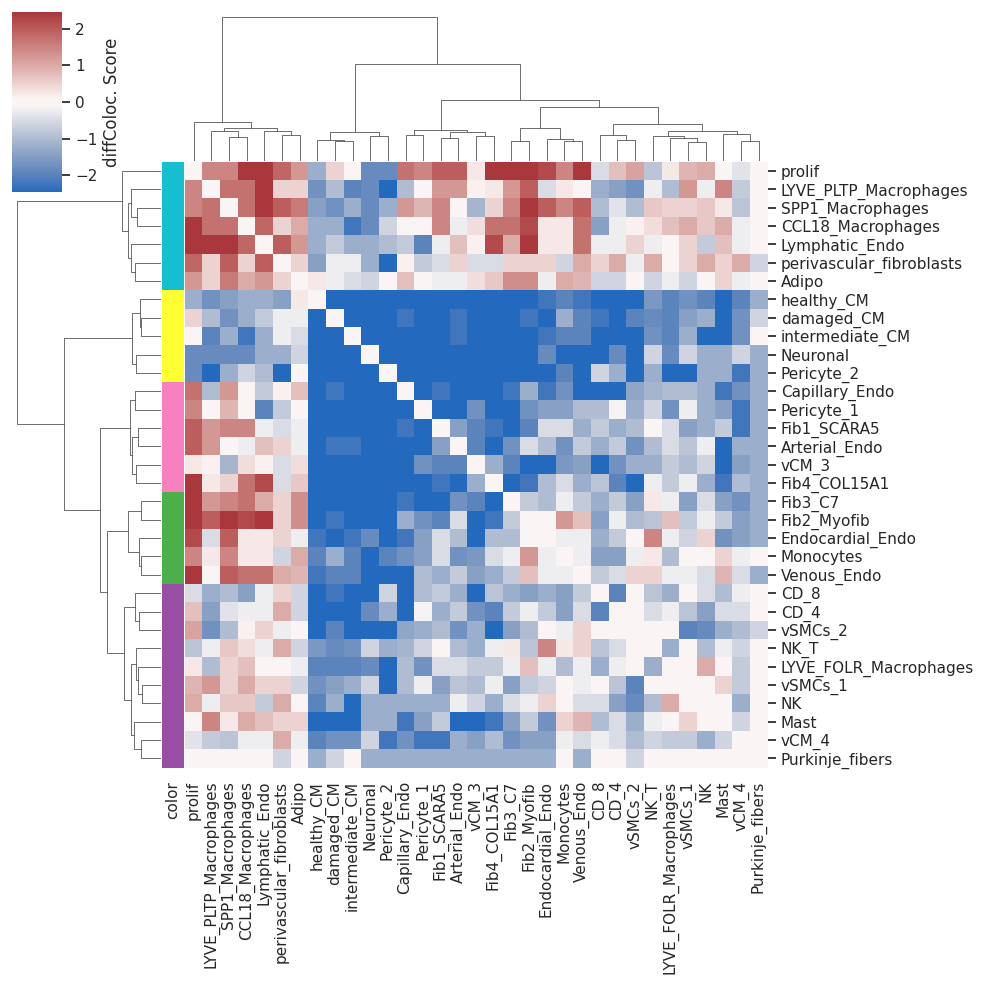

In [17]:
## Plot improved heatmap
sns.set(font_scale=1)
plot=sns.clustermap(myo_isc_HM, cmap='vlag', center=0, method='ward', cbar_kws={'label': 'diffColoc. Score'}, row_colors=niches_df.color)

Now we will filter non significant co-localization differences

In [18]:
#### Filter test HM
myo_isc_HM=nichesphere.tl.pval_filtered_HMdf(testDF=myo_iscDF, oneCTinteractions=oneCTints, p=0.1, cell_types=cell_types)

In [19]:
#Remove cells with no significant co-localization differences or just one enriched interaction
myo_isc_HM=myo_isc_HM.loc[myo_isc_HM.sum()!=0,myo_isc_HM.sum()!=0]
#myo_isc_HM=myo_isc_HM.loc[(myo_isc_HM!=0).sum()>1,(myo_isc_HM!=0).sum()>1]

Differential co-localization network

To build the differential co-localization network, we will get an adjacency matrix (adj) based on the cosine similarities of the distributions of significant differential co-localization scores for the different cell types

In [20]:
##Cosine similarity plus pseudocount
adj=pd.DataFrame(sklearn.metrics.pairwise.cosine_similarity(myo_isc_HM)+1)
adj.index=myo_isc_HM.index
adj.columns=myo_isc_HM.columns

In [21]:
##Cell pairs with not significant differential co-localization get 0
adj[myo_isc_HM==0]=0
adj[adj==1]=0

Then the network is built just taking into account the differentially co-localized cell type pairs. The cell groups dictionary can be used here to visualize different cell groups in different colors.

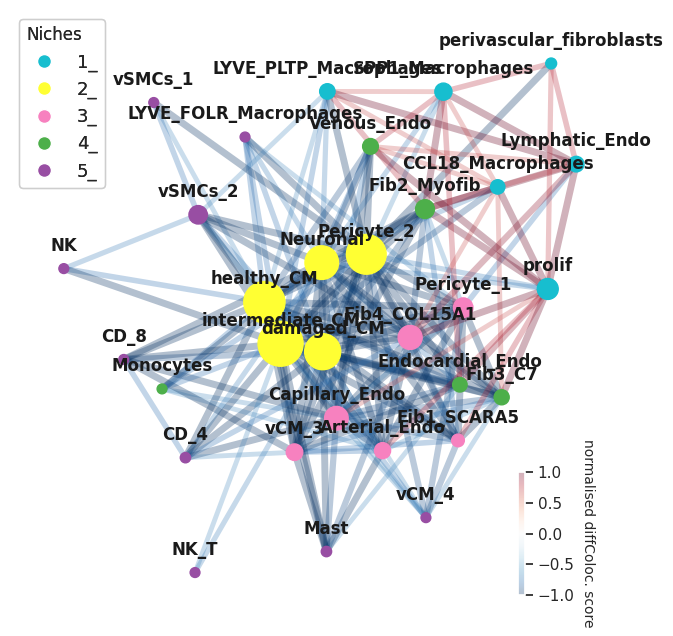

In [22]:
plt.rcParams['axes.facecolor'] = "None"
gCol=nichesphere.coloc.colocNW(x_diff=myo_isc_HM, adj=adj,cell_group=niches_dict, clist=clist, BTsizedNodes=True)

legend_elements1 = [plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.tab10.colors[9], lw=4, label='1_', ms=10),
                    plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[5], lw=4, label='2_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[7], lw=4, label='3_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[2], lw=4, label='4_', ms=10),
                   plt.Line2D([0], [0], marker="o" ,color='w', markerfacecolor=plt.cm.Set1.colors[3], lw=4, label='5_', ms=10),
                   ]

plt.gca().add_artist(plt.legend(handles=legend_elements1,loc='upper left', fontsize=13, title='Niches', alignment='left'))

We can then calculate some network statistics with the networkX package [ref] functions:

In [23]:
t1=pd.DataFrame({'influencer':[nx.eigenvector_centrality(gCol)[x] for x in list(gCol.nodes)], 'betweenness':[nx.betweenness_centrality(gCol)[x] for x in list(gCol.nodes)], 
                 'degree':[nx.degree_centrality(gCol)[x] for x in list(gCol.nodes)], 'pagerank':[nx.pagerank(gCol, weight=None)[x] for x in list(gCol.nodes)]})
t1.index=list(gCol.nodes)

And visualize them

Text(0.5, 1.0, 'Betweenness')

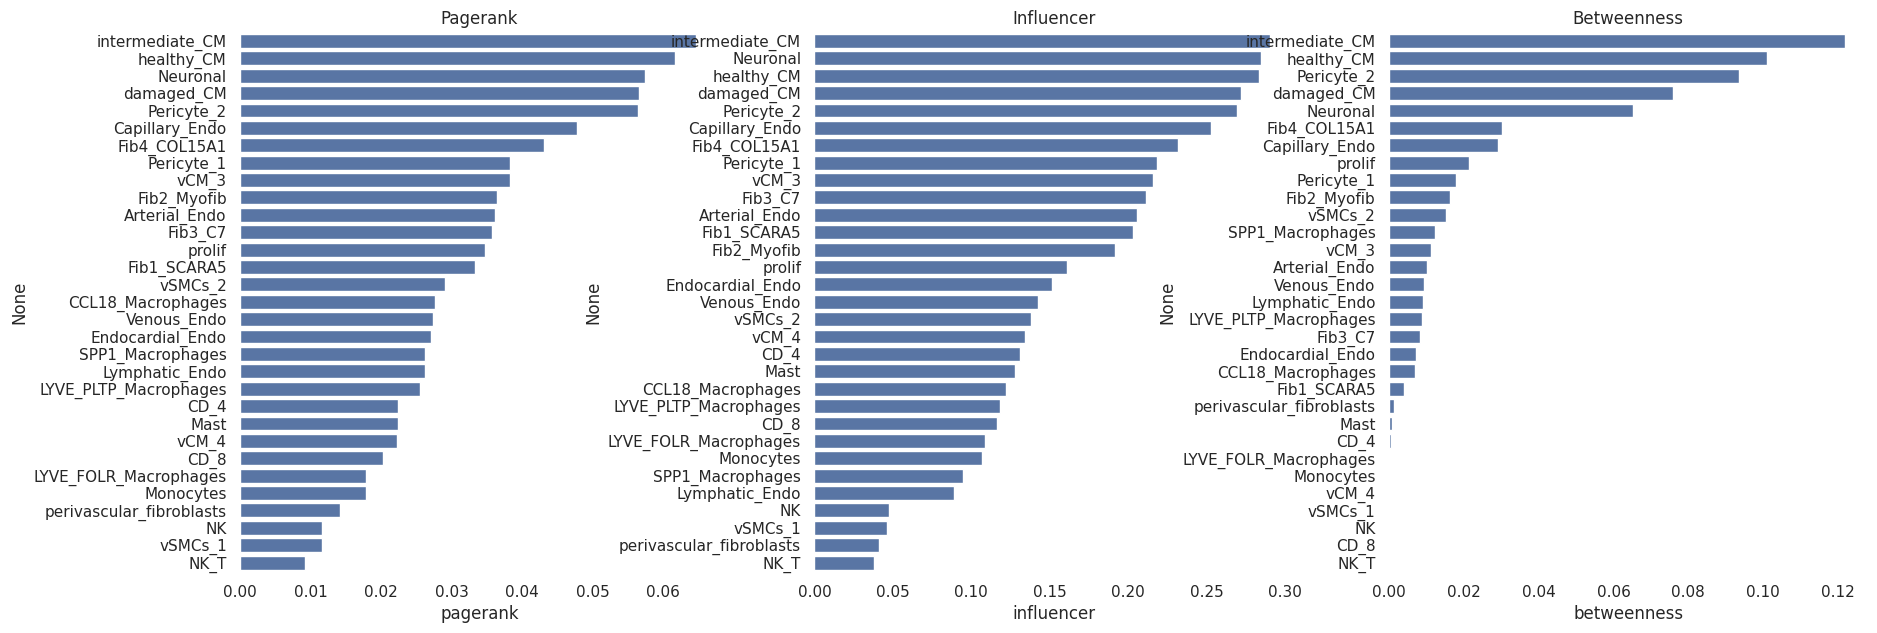

In [24]:

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
sns.barplot(ax=axes[0], y=t1.sort_values('pagerank', ascending=False).index, x='pagerank', data=t1.sort_values('pagerank', ascending=False))
axes[0].set_title('Pagerank')
sns.barplot(ax=axes[1], y=t1.sort_values('influencer', ascending=False).index, x='influencer', data=t1.sort_values('influencer', ascending=False))
axes[1].set_title('Influencer')
sns.barplot(ax=axes[2], y=t1.sort_values('betweenness', ascending=False).index, x='betweenness', data=t1.sort_values('betweenness', ascending=False))
axes[2].set_title('Betweenness')
#plt.savefig('../../../../figures_nichesphere_tutorial/diffColocNW_stats.pdf')

In [25]:
## Niche plots

In [26]:
## Series of sample names with spot ids as indexes 
spotSamples=mudata['visium'].obs.patient_region_id

In [27]:
## put spatial coordinates in uns.spatial
mudata['visium'].uns['spatial']=mudata['visium'].obsm['X_spatial']

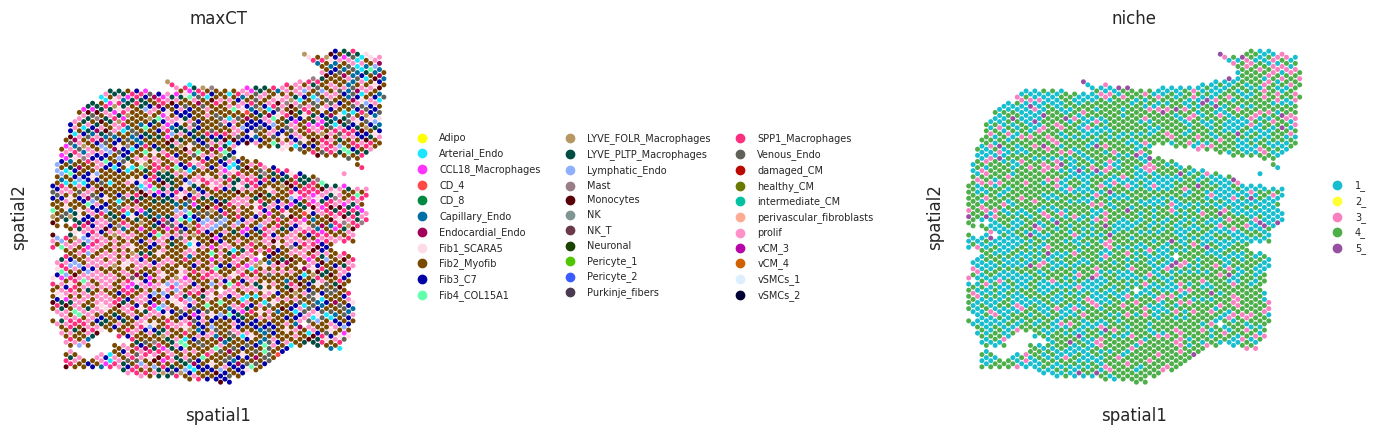

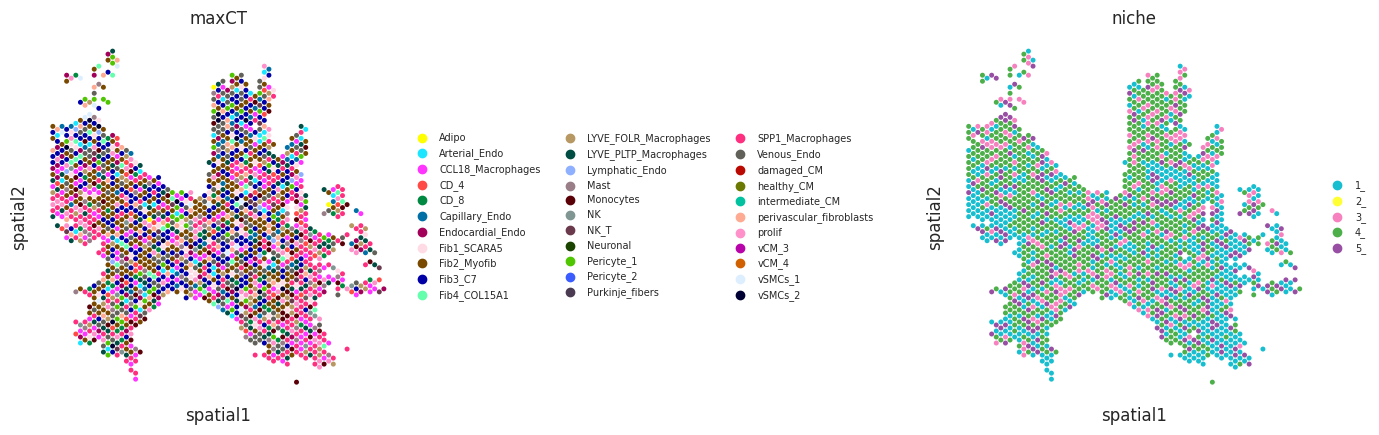

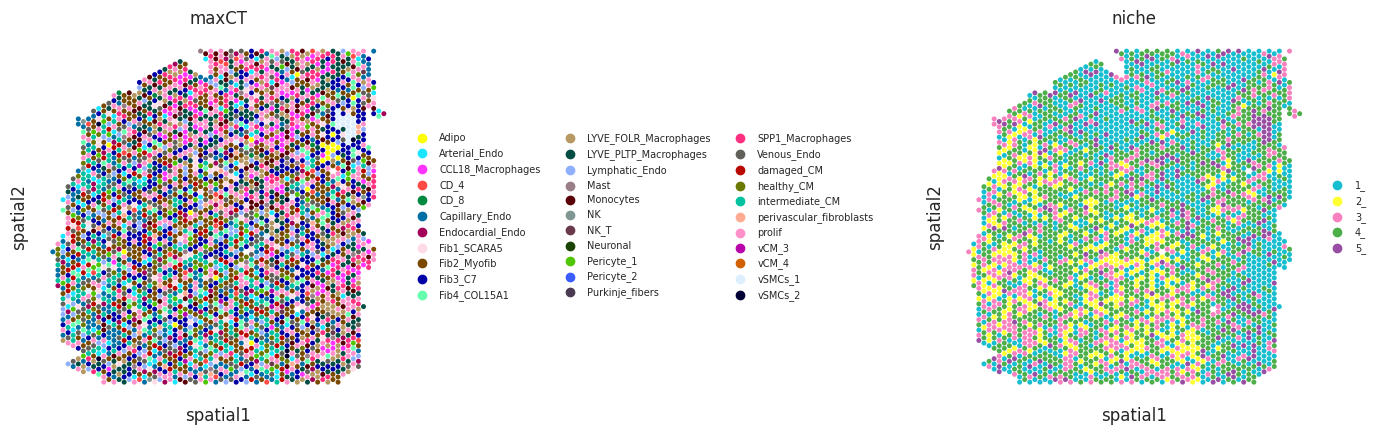

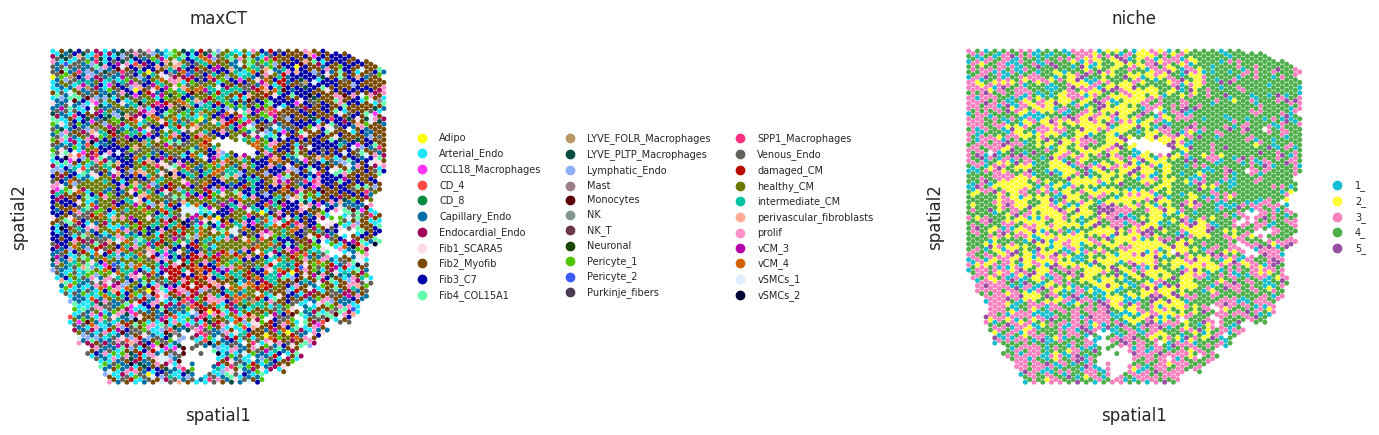

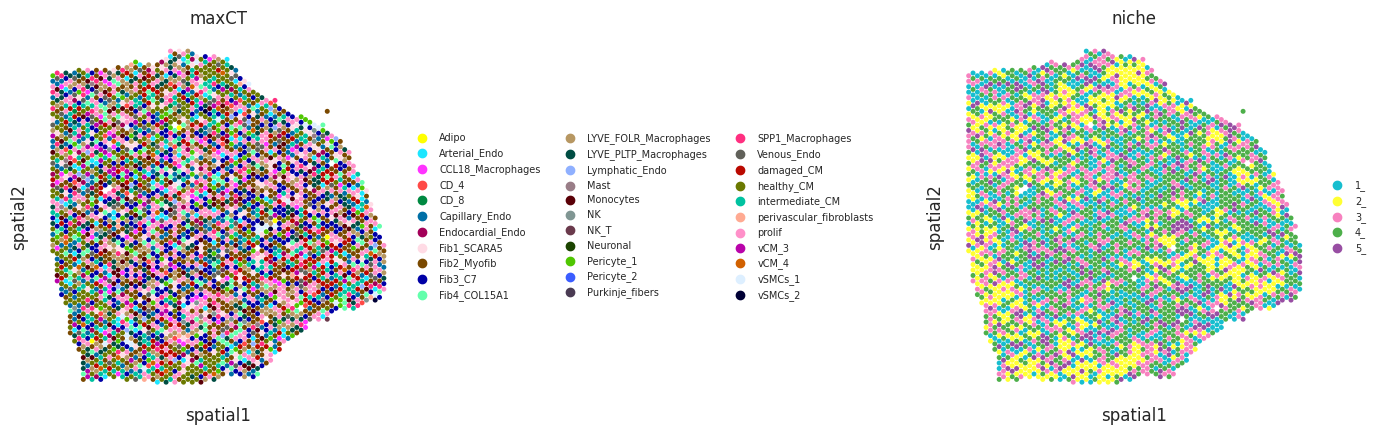

In [28]:
for smpl in  list(sampleTypesDF['sample'][sampleTypesDF.sampleType=='ischemic']):  
    
    nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]], cell_types=mudata['sc'].obs.cell_subtype2, nicheDF=niches_df, spot_size=0.015, 
                     niche_colors=niche_cols, legend_fontsize=7, wspace=0.5)


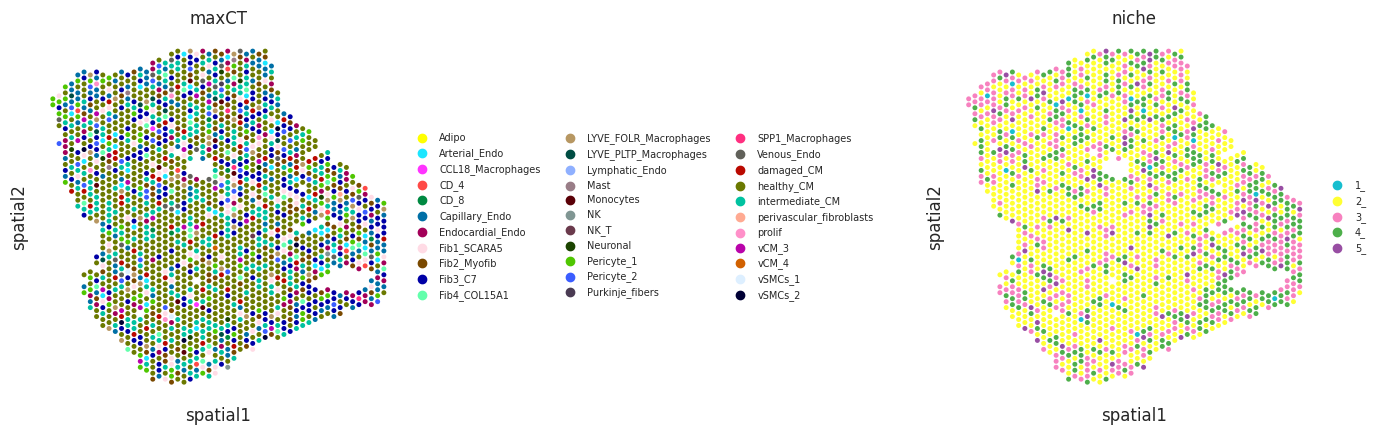

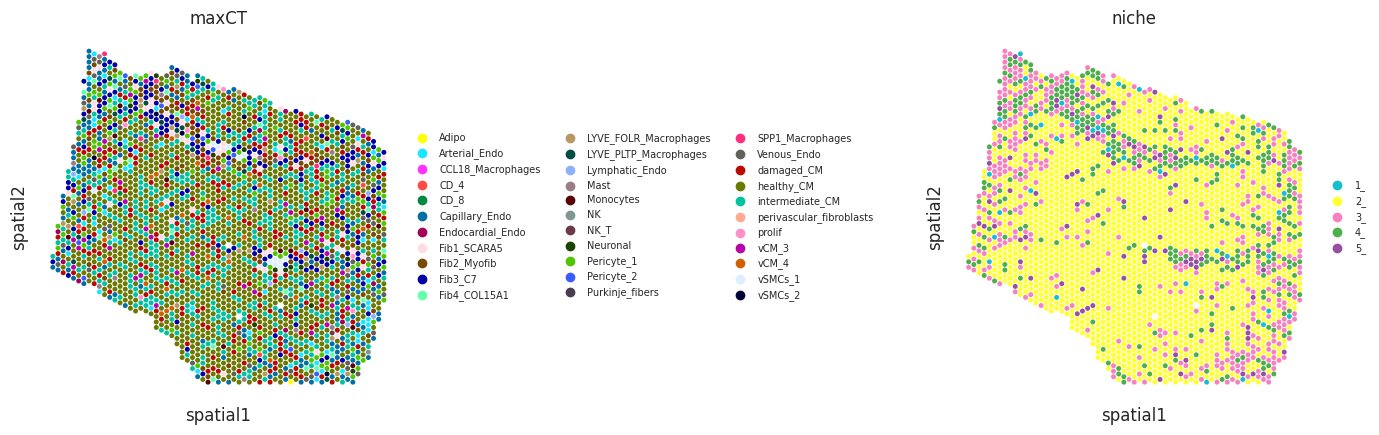

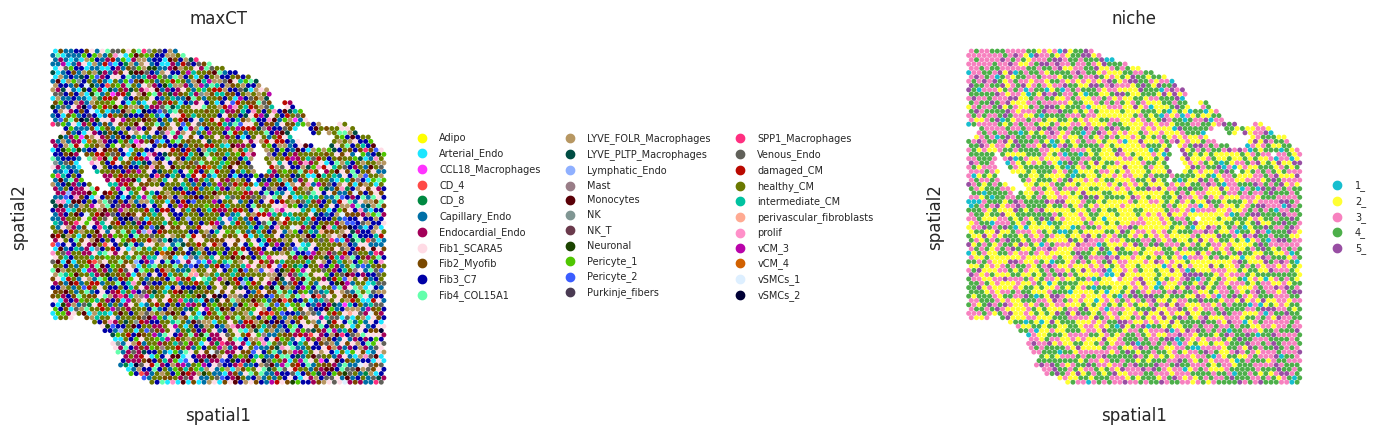

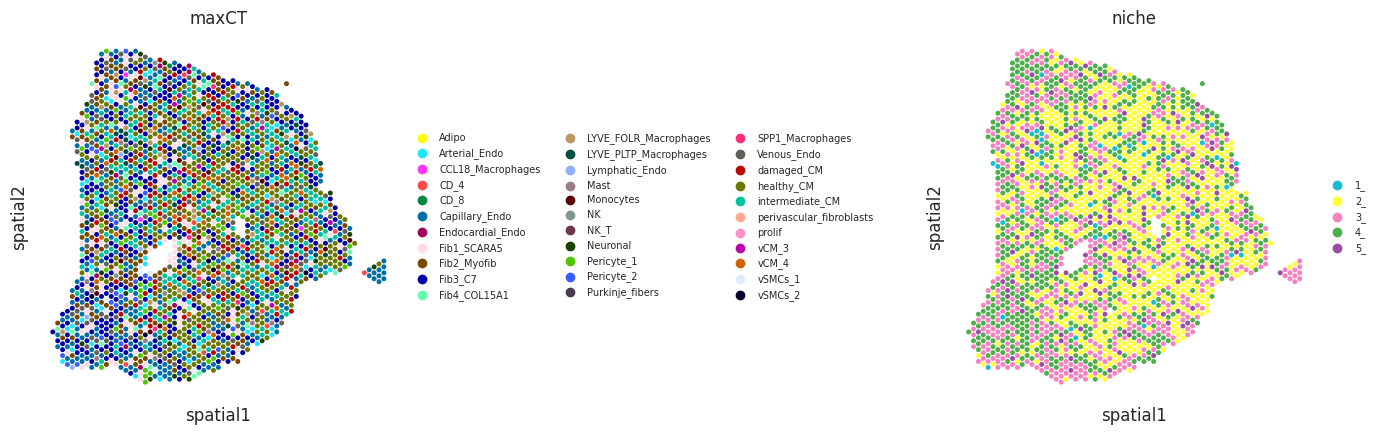

In [29]:
for smpl in  list(sampleTypesDF['sample'][sampleTypesDF.sampleType=='myogenic']):
    
   nichesphere.coloc.spatialNichePlot(adata=mudata['visium'][mudata['visium'].obs.patient_region_id==smpl].copy(), CTprobs=CTprops.loc[spotSamples.index[spotSamples==smpl]], cell_types=mudata['sc'].obs.cell_subtype2, nicheDF=niches_df, spot_size=0.015, 
                     niche_colors=niche_cols, legend_fontsize=7, wspace=0.5)